In [34]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

import pyro
import pyro.distributions as dist
from pyro.distributions.torch import Bernoulli
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro import poutine

plt.style.use("seaborn-v0_8")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pyro.set_rng_seed(0)
np.random.seed(0)
n = 100
sigma = np.random.uniform(0, 50, size=(n,))
beta = np.random.normal(0, 10, size=(n,))
alpha = np.random.normal(178, 20, size=(n,))
gender = np.random.binomial(1, np.random.uniform(0, 1, (n, )))
mu = gender * beta + alpha
height = np.random.normal(mu, sigma)

In [3]:
height

array([181.81349004, 150.69023635, 193.91181352, 135.66406962,
       197.01511819, 127.47459434, 165.82001869, 185.90731305,
       194.7015847 , 206.65344278, 166.21846175, 157.83209771,
       157.06868165, 149.52933184, 188.28336474, 185.20818604,
       194.00899888, 206.08911669, 235.71986656, 296.66707515,
       166.50591549,  71.76979299, 191.88698832, 198.82436469,
       187.74216714, 114.34218895, 174.36551442, 164.33007258,
       189.70820968, 240.85977627, 183.49823693, 162.70190179,
       141.52881966, 175.81923202, 157.21668097, 153.1396896 ,
       169.22275397, 162.14016825, 305.23906642, 220.27683775,
       186.35736175, 140.80409556, 211.0775836 , 189.12322402,
       165.95577165, 213.78427304, 171.5707338 , 179.90833573,
       179.65804049, 124.94770202, 192.66352108, 180.26383036,
       164.88414053, 187.44608403, 144.11987432, 190.80150226,
       249.58584214, 150.95621522, 249.3890907 , 190.63470668,
       145.10418901, 167.21663138, 143.6005731 , 171.50

In [4]:
man_height = height[gender == 1]
female_height = height[gender == 0]

In [5]:
man_height = torch.from_numpy(man_height).float()
female_height = torch.from_numpy(female_height).float()

(array([ 2.,  6.,  6., 13., 17.,  4.,  2.,  1.]),
 array([ 71.76979065,  99.88195038, 127.99411011, 156.10627747,
        184.21844482, 212.33059692, 240.44276428, 268.55493164,
        296.66708374]),
 <BarContainer object of 8 artists>)

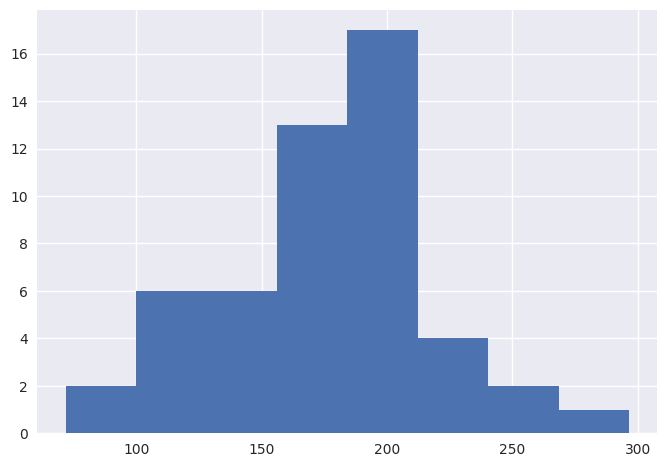

In [6]:
plt.hist(man_height, bins=8)

(array([ 5., 11., 15., 10.,  5.,  2.,  0.,  1.]),
 array([114.34218597, 138.20429993, 162.06640625, 185.92851257,
        209.79063416, 233.65274048, 257.51486206, 281.37695312,
        305.23907471]),
 <BarContainer object of 8 artists>)

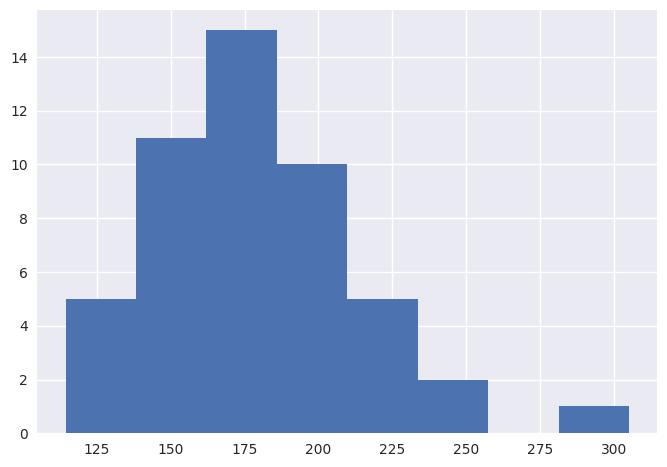

In [7]:
plt.hist(female_height, bins=8)

In [8]:
def model(man_height=None, female_height=None, n1=1, n2=1):
    if man_height is not None:
        n1, n2 = man_height.shape[0], female_height.shape[0]
        assert n1 + n2 == n, "Invalid size"
        
    with pyro.plate("man_plate_height", n1):
        sigma = pyro.sample("man_sigma", dist.Uniform(0, 50))
        beta = pyro.sample("man_beta", dist.Normal(0, 10))
        alpha = pyro.sample("man_alpha", dist.Normal(178, 20,))
        mu = beta + alpha
        man_height_sample =  pyro.sample("man_height", dist.Normal(mu, sigma,),  obs=man_height)
    
    
    with pyro.plate("female_plate_height", n2):
        sigma = pyro.sample("female_sigma", dist.Uniform(0, 50))
        beta = pyro.sample("female_beta", dist.Normal(0, 10))
        alpha = pyro.sample("female_alpha", dist.Normal(178, 20,))
        mu = alpha
        female_height_sample =  pyro.sample("female_height", dist.Normal(mu, sigma, ), obs=female_height)

    return {"man_height_sample": man_height_sample, "female_height_sample": female_height_sample}

def guide(man_height=None, female_height=None, n1=1, n2=1):
    if man_height is not None:
        n1, n2 = man_height.shape[0], female_height.shape[0]
        assert n1 + n2 == n, "Invalid size"
    
    hloc_param = pyro.param("height_loc", lambda: torch.normal(150, 20, (2, )))
    hscale_param = pyro.param("height_scale", torch.tensor([5.0, 2.0]), 
                              constraint=constraints.positive)
    with pyro.plate("man_plate_height", n1):
        sigma = pyro.sample("man_sigma", dist.Uniform(0, 50))
        beta = pyro.sample("man_beta", dist.Normal(0, 10))
        alpha = pyro.sample("man_alpha", dist.Normal(178, 20,))
        man_height_sample = pyro.sample("man_height", dist.Normal(hloc_param[0], hscale_param[0]))
    with pyro.plate("female_plate_height", n2):
        pyro.sample("female_sigma", dist.Uniform(0, 50))
        pyro.sample("female_beta", dist.Normal(0, 10))
        pyro.sample("female_alpha", dist.Normal(178, 20,))
        female_height_sample = pyro.sample("female_height", dist.Normal(hloc_param[1], hscale_param[1]))
    

In [9]:
pyro.clear_param_store()

In [10]:
guide_trace = poutine.trace(guide).get_trace(man_height, female_height)

In [11]:
guide_trace.nodes

OrderedDict([('_INPUT',
              {'name': '_INPUT',
               'type': 'args',
               'args': (tensor([181.8135, 193.9118, 197.0151, 127.4746, 165.8200, 185.9073, 194.7016,
                        166.2185, 157.0687, 188.2834, 185.2082, 194.0090, 235.7199, 296.6671,
                        166.5059,  71.7698, 191.8870, 198.8244, 164.3301, 189.7082, 240.8598,
                        162.7019, 162.1402, 220.2768, 186.3574, 140.8041, 211.0776, 165.9558,
                        249.5858, 150.9562, 145.1042, 143.6006, 199.4131, 209.6254, 141.2627,
                        108.0288, 223.9379, 187.9543, 127.7023, 125.0931, 157.1712, 176.4797,
                        238.1616, 120.7136, 178.1031, 134.4910, 160.1452, 210.1104, 210.0712,
                        122.2016,  79.7917]),
                tensor([150.6902, 135.6641, 206.6534, 157.8321, 149.5293, 206.0891, 187.7422,
                        114.3422, 174.3655, 183.4982, 141.5288, 175.8192, 157.2167, 153.1397,
            

In [12]:
model_trace = poutine.trace(poutine.replay(model, trace=guide_trace)).get_trace(man_height, female_height)

In [13]:
model_trace.nodes

OrderedDict([('_INPUT',
              {'name': '_INPUT',
               'type': 'args',
               'args': (tensor([181.8135, 193.9118, 197.0151, 127.4746, 165.8200, 185.9073, 194.7016,
                        166.2185, 157.0687, 188.2834, 185.2082, 194.0090, 235.7199, 296.6671,
                        166.5059,  71.7698, 191.8870, 198.8244, 164.3301, 189.7082, 240.8598,
                        162.7019, 162.1402, 220.2768, 186.3574, 140.8041, 211.0776, 165.9558,
                        249.5858, 150.9562, 145.1042, 143.6006, 199.4131, 209.6254, 141.2627,
                        108.0288, 223.9379, 187.9543, 127.7023, 125.0931, 157.1712, 176.4797,
                        238.1616, 120.7136, 178.1031, 134.4910, 160.1452, 210.1104, 210.0712,
                        122.2016,  79.7917]),
                tensor([150.6902, 135.6641, 206.6534, 157.8321, 149.5293, 206.0891, 187.7422,
                        114.3422, 174.3655, 183.4982, 141.5288, 175.8192, 157.2167, 153.1397,
            

In [31]:
pyro.clear_param_store()
svi = SVI(model, guide, pyro.optim.SGD({"lr": 2e-5}), Trace_ELBO())
losses = []
for i in range(200):
    loss = svi.step(man_height, female_height)
    losses.append(loss)

/env_nlp/lib/python3.9/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'man_height', 'female_height'}
  warnings.warn(


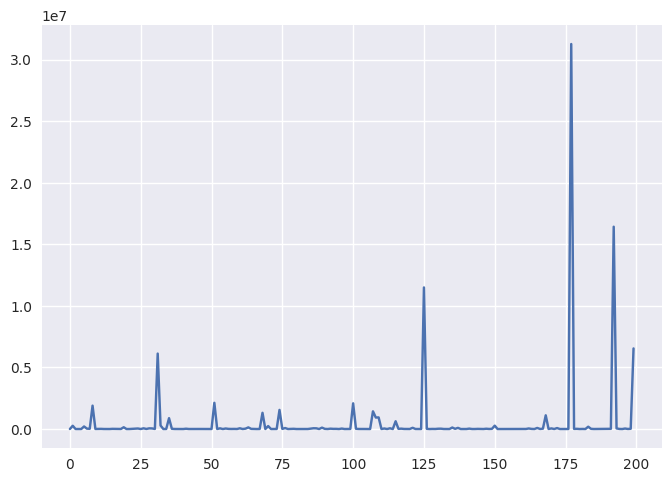

In [32]:
plt.plot(losses)

In [33]:
for name, param in pyro.get_param_store().items():
    print(name, param)

height_loc tensor([149.8338, 151.3479], requires_grad=True)
height_scale tensor([6.1314, 2.4331], grad_fn=<AddBackward0>)
